# The history of publishing delays by Daniel Himmelstein

In [1]:
library(dplyr, warn=F)
library(ggplot2)

## Prepare acceptance and publication delay dataframes

In [2]:
# Read history dates for all articles
path = file.path('data', 'articles-all.tsv.bz2')
col_types = list(
  accepted = readr::col_date(),
  received = readr::col_date(),
  date_online = readr::col_date(),
  revised = readr::col_date()
)
all_df = readr::read_tsv(path, col_types = col_types)
head(all_df, 2)

,journal,journal_nlm_id,pubmed_id,accepted,journal_issn,received,date_online,aheadofprint,revised,epublish,pmc-release,ecollection,ppublish,medline,pubmed,entrez
1,Arch Gerontol Geriatr,8214379,2416282,1985-05-02,0167-4943,1985-01-25,NA,NA,1985-04-30,NA,NA,NA,NA,NA,NA,NA
2,Arch Gerontol Geriatr,8214379,2421656,1985-09-19,0167-4943,1985-01-22,NA,NA,1985-09-18,NA,NA,NA,NA,NA,NA,NA


In [3]:
# Set time constraint to elimate erroneous records
earliest = readr::parse_date('1950-01-01')
latest = readr::parse_date('2015-12-31')

In [4]:
# Create an acceptance delay dataset
accept_df = all_df %>%
  dplyr::mutate(acceptance_delay = as.numeric(accepted - received, units='days')) %>%
  dplyr::select(journal_nlm_id, pubmed_id, accepted, acceptance_delay) %>%
  dplyr::filter(! is.na(acceptance_delay)) %>%
  dplyr::filter(acceptance_delay > 0) %>%
  dplyr::filter(acceptance_delay <= 365 * 3) %>%
  dplyr::filter(accepted >= earliest) %>%
  dplyr::filter(accepted <= latest) %>%
  dplyr::arrange(accepted, pubmed_id)

path = file.path('data', 'acceptance-delays.tsv')
accept_df %>%
  readr::write_tsv(path)
system2('gzip', c('--force', path))

head(accept_df, 2)

,journal_nlm_id,pubmed_id,accepted,acceptance_delay
1,2984816R,18959845,1965-07-31,121
2,2984816R,18959840,1965-08-03,87


In [5]:
nrow(accept_df)

[1] 3238646

In [6]:
# Create a publication delay dataset
publish_df = all_df %>%
  dplyr::mutate(publication_delay = as.numeric(date_online - accepted, units='days')) %>%
  dplyr::select(journal_nlm_id, pubmed_id, date_online, publication_delay) %>%
  dplyr::filter(! is.na(publication_delay)) %>%
  dplyr::filter(publication_delay >= 0) %>%
  dplyr::filter(publication_delay <= 365 * 2) %>%
  dplyr::filter(date_online >= earliest) %>%
  dplyr::filter(date_online <= latest) %>%
  dplyr::arrange(date_online, pubmed_id)

path = file.path('data', 'publication-delays.tsv')
publish_df %>%
  readr::write_tsv(path)
system2('gzip', c('--force', path))

head(publish_df, 2)

,journal_nlm_id,pubmed_id,date_online,publication_delay
1,9801902,11056693,1997-08-13,211
2,9801902,11056694,1997-08-13,65


In [7]:
nrow(publish_df)

[1] 2661145

## Prepare journal dataframe

In [8]:
journal_df = file.path('data', 'pubmed-journals.tsv') %>%
  readr::read_tsv() %>%
  dplyr::transmute(journal_nlm_id = NlmId, journal_abbrev = MedAbbr, journal = JournalTitle)

In [9]:
journal_df = journal_df %>%
  dplyr::left_join(
    accept_df %>%
      dplyr::group_by(journal_nlm_id) %>%
      dplyr::summarize(
        'acceptance_delays' = n(),
        'unique_acceptance_dates' = length(unique(accepted)),
        'unique_acceptance_delays' = length(unique(acceptance_delay))
      )
  ) %>%
  dplyr::left_join(
    publish_df %>%
      dplyr::group_by(journal_nlm_id) %>%
      dplyr::summarize(
        'publication_delays' = n(),
        'unique_publication_dates' = length(unique(date_online)),
        'unique_publication_delays' = length(unique(publication_delay))
      )
  ) %>%
  dplyr::filter(!(is.na(acceptance_delays) & is.na(publication_delays)))

Joining by: "journal_nlm_id"
Joining by: "journal_nlm_id"


In [10]:
journal_df %>%
  readr::write_tsv(file.path('data', 'journal-summaries.tsv'), na = '')
head(journal_df, 2)

,journal_nlm_id,journal_abbrev,journal,acceptance_delays,unique_acceptance_dates,unique_acceptance_delays,publication_delays,unique_publication_dates,unique_publication_delays
1,0370270,Acta Anaesthesiol Scand,Acta anaesthesiologica Scandinavica,140,109,92,545,248,70
2,14520300R,Acta Biochim Pol,Acta biochimica Polonica,1303,835,317,990,339,113


## Visualize acceptance delay trends

### Percentile by year plot

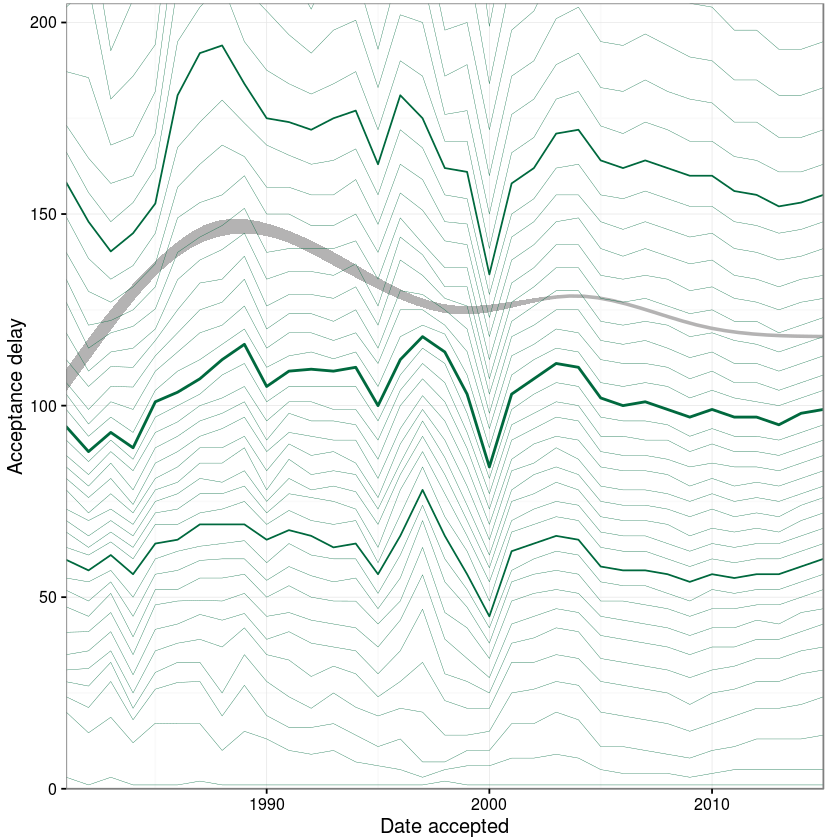

In [11]:
summarize_year <- function(df) {
  probs = seq(0, 1, 0.025)
  dplyr::data_frame(
    percentile = 100 * probs,
    delay = quantile(df$acceptance_delay, probs=probs),
    articles = nrow(df)
  )
}

year_df = accept_df %>%
  dplyr::mutate(year_accepted = lubridate::year(accepted)) %>%
  dplyr::group_by(year_accepted) %>%
  dplyr::do(summarize_year(.))

year_df %>%
  format(digits=3) %>%
  readr::write_tsv(file.path('data', 'acceptance-percentiles.tsv'))  

gg = year_df %>%
  ggplot2::ggplot(aes(x = year_accepted, y = delay, group = percentile)) +
  ggplot2::geom_smooth(aes(group=NULL),
      data=accept_df %>% dplyr::mutate(year_accepted = lubridate::year(accepted), delay = acceptance_delay),
      color='#B4B3B3', fill = '#B4B3B3', alpha=1) +
  ggplot2::geom_line(size=0.1, color = '#00693E') +
  ggplot2::geom_line(data = dplyr::filter(year_df, percentile == 50), size=0.8, color = '#00693E') +
  ggplot2::geom_line(data = dplyr::filter(year_df, percentile %in% c(25, 75)), size=0.5, color = '#00693E') +
  ggplot2::coord_cartesian(xlim = c(1981, 2015), ylim = c(0, 205), expand = FALSE) +
  ggplot2::theme_bw() +
  ggplot2::xlab('Date accepted') +
  ggplot2::ylab('Acceptance delay') +
  ggplot2::theme(plot.margin=grid::unit(c(2, 10, 2, 2), 'points'))

path = file.path('viz', 'acceptance-by-article.png')
ggplot2::ggsave(filename = path, plot = gg, width = 5.5, height = 0.75 * 5.5)

gg

### Journal-specific acceptance delay histories

In [12]:
# Identify the subset of journals with sufficient data
journal_accept_df = journal_df %>%
  dplyr::filter(acceptance_delays >= 100) %>%
  dplyr::filter(unique_acceptance_dates >= 2) %>%
  dplyr::filter(unique_acceptance_delays >= 3)

nrow(journal_accept_df)

[1] 2901

In [13]:
for (i in 1:nrow(journal_accept_df)) {
  nlm_id = journal_accept_df$journal_nlm_id[i]
  journal_abbrev = journal_accept_df$journal_abbrev[i]
  df = accept_df %>%
    dplyr::filter(journal_nlm_id == nlm_id) %>%
    dplyr::mutate(accepted_decimal = lubridate::decimal_date(accepted))
  
  xlimits = boxplot.stats(df$accepted_decimal, coef = 3)$stats[c(1, 5)]
  ylimits = boxplot.stats(df$acceptance_delay, coef = 3)$stats[c(1, 5)]
    
  gg = df %>%
    ggplot2::ggplot(aes(x = accepted_decimal, y = acceptance_delay)) +
    ggplot2::geom_point(alpha=log(nrow(df))^-1.02 - 0.02, color='#e60000') +
    ggplot2::geom_smooth(linetype=0, fill='#454343', alpha=0.56) +
    ggplot2::coord_cartesian(xlim = xlimits, ylim = ylimits) +
    ggplot2::theme_bw() +
    ggplot2::xlab('Date accepted') +
    ggplot2::ylab('Acceptance delay') +
    ggplot2::ggtitle(label = journal_abbrev) +
    ggplot2::theme(plot.margin=grid::unit(c(2, 10, 2, 2), 'points'))
  path = file.path('viz', 'journal', 'accept', sprintf('%s.png', nlm_id))
  ggplot2::ggsave(filename = path, plot = gg, width = 5.5, height = 0.75 * 5.5, dpi = 150)
}

Warning message:
In simpleLoess(y, x, w, span, degree, parametric, drop.square, normalize, : pseudoinverse used at 2007.8Warning message:
In simpleLoess(y, x, w, span, degree, parametric, drop.square, normalize, : neighborhood radius 0.68709Warning message:
In simpleLoess(y, x, w, span, degree, parametric, drop.square, normalize, : reciprocal condition number  1.6048e-30Warning message:
In simpleLoess(y, x, w, span, degree, parametric, drop.square, normalize, : There are other near singularities as well. 0.4721Warning message:
In predLoess(y, x, newx, s, weights, pars$robust, pars$span, pars$degree, : pseudoinverse used at 2007.8Warning message:
In predLoess(y, x, newx, s, weights, pars$robust, pars$span, pars$degree, : neighborhood radius 0.68709Warning message:
In predLoess(y, x, newx, s, weights, pars$robust, pars$span, pars$degree, : reciprocal condition number  1.6048e-30Warning message:
In predLoess(y, x, newx, s, weights, pars$robust, pars$span, pars$degree, : There are other ne

## Visualize online publication delay trends

### Percentile by year plot

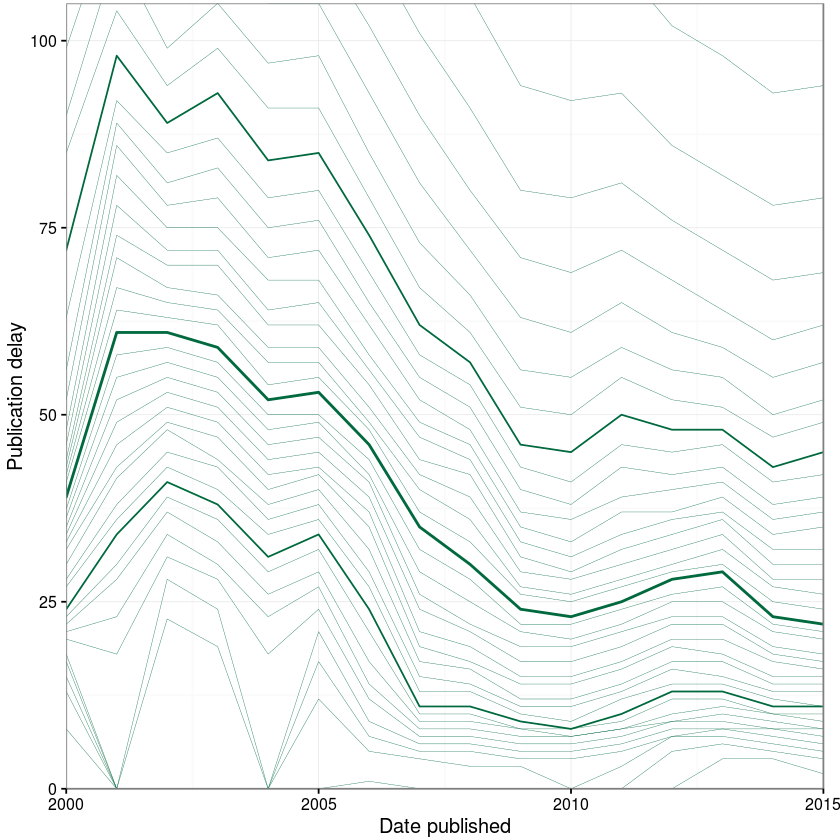

In [14]:
summarize_year <- function(df) {
  probs = seq(0, 1, 0.025)
  dplyr::data_frame(
    percentile = 100 * probs,
    delay = quantile(df$publication_delay, probs=probs),
    articles = nrow(df)
  )
}

year_df = publish_df %>%
  dplyr::mutate(year_published = lubridate::year(date_online)) %>%
  dplyr::group_by(year_published) %>%
  dplyr::do(summarize_year(.))

year_df %>%
  format(digits=3) %>%
  readr::write_tsv(file.path('data', 'publication-percentiles.tsv'))  

gg = year_df %>%
  ggplot2::ggplot(aes(x = year_published, y = delay, group = percentile)) +
  #ggplot2::geom_smooth(aes(group=NULL),
  #    data=publish_df %>% dplyr::mutate(year_published = lubridate::year(date_online), delay = publication_delay),
  #    color='#B4B3B3', fill = '#B4B3B3', alpha=1) +
  ggplot2::geom_line(size=0.1, color = '#00693E') +
  ggplot2::geom_line(data = dplyr::filter(year_df, percentile == 50), size=0.8, color = '#00693E') +
  ggplot2::geom_line(data = dplyr::filter(year_df, percentile %in% c(25, 75)), size=0.5, color = '#00693E') +
  ggplot2::coord_cartesian(xlim=c(2000, 2015), ylim = c(0, 105), expand = FALSE) +
  ggplot2::theme_bw() +
  ggplot2::xlab('Date published') +
  ggplot2::ylab('Publication delay') +
  ggplot2::theme(plot.margin=grid::unit(c(2, 10, 2, 2), 'points'))

path = file.path('viz', 'publication-by-article.png')
ggplot2::ggsave(filename = path, plot = gg, width = 5.5, height = 0.75 * 5.5)

gg

### Journal-specific publication delay histories

In [15]:
# Identify the subset of journals with sufficient data
journal_publish_df = journal_df %>%
  dplyr::filter(publication_delays >= 100) %>%
  dplyr::filter(unique_publication_dates >= 2) %>%
  dplyr::filter(unique_publication_delays >= 3)

nrow(journal_publish_df)

[1] 2564

In [16]:
for (i in 1:nrow(journal_publish_df)) {
  nlm_id = journal_publish_df$journal_nlm_id[i]
  journal_abbrev = journal_publish_df$journal_abbrev[i]
  df = publish_df %>%
    dplyr::filter(journal_nlm_id == nlm_id) %>%
    dplyr::mutate(date_online_decimal = lubridate::decimal_date(date_online))
  
  xlimits = boxplot.stats(df$date_online_decimal, coef = 3)$stats[c(1, 5)]
  ylimits = boxplot.stats(df$publication_delay, coef = 3)$stats[c(1, 5)]
    
  gg = df %>%
    ggplot2::ggplot(aes(x = date_online_decimal, y = publication_delay)) +
    ggplot2::geom_point(alpha=log(nrow(df))^-1.02 - 0.02, color='#e60000') +
    ggplot2::geom_smooth(linetype=0, fill='#454343', alpha=0.56) +
    ggplot2::coord_cartesian(xlim = xlimits, ylim = ylimits) +
    ggplot2::theme_bw() +
    ggplot2::xlab('Date published') +
    ggplot2::ylab('Publication delay') +
    ggplot2::ggtitle(label = journal_abbrev) +
    ggplot2::theme(plot.margin=grid::unit(c(2, 10, 2, 2), 'points'))
  path = file.path('viz', 'journal', 'publish', sprintf('%s.png', nlm_id))
  ggplot2::ggsave(filename = path, plot = gg, width = 5.5, height = 0.75 * 5.5, dpi = 150)
}

## Summarize each year

In [17]:
year_summary_df = accept_df %>%
  dplyr::mutate(year = lubridate::year(accepted)) %>%
  dplyr::group_by(year) %>%
  dplyr::summarize(
    n_journals_accept = n_distinct(journal_nlm_id),
    n_articles_accept = n(),
    median_delay_accept = median(acceptance_delay)
  ) %>% dplyr::full_join(
  publish_df %>%
    dplyr::mutate(year = lubridate::year(date_online)) %>%
    dplyr::group_by(year) %>%
    dplyr::summarize(
      n_journals_publish = n_distinct(journal_nlm_id),
      n_articles_publish = n(),
      median_delay_publish = median(publication_delay)
    )
  )

year_summary_df[is.na(year_summary_df)] <- 0

year_summary_df %>%
  readr::write_tsv(file.path('data', 'year-summaries.tsv'))

head(year_summary_df, 2)

Joining by: "year"


,year,n_journals_accept,n_articles_accept,median_delay_accept,n_journals_publish,n_articles_publish,median_delay_publish
1,1965,1,85,91,0,0,0
2,1966,1,191,60,0,0,0


## Slope plot

In [18]:
get_beta = function(df, date_var, delay_var) {
  # Regress delay_var against date_vat and return model information
  lm_formula = as.formula(paste0(delay_var, ' ~ ', date_var))
  model = lm(lm_formula, data = df)
  model_df = broom::tidy(model)
  row_df = dplyr::data_frame(
    articles = nrow(df),
    slope = model_df$estimate[2],
    slope_as_percent = 100 * model_df$estimate[2] / mean(df[[delay_var]]),
    p_value = model_df$p.value[2]
  )
  return(row_df)
}

slope_df = dplyr::bind_rows(
  accept_df %>%
    dplyr::filter(journal_nlm_id %in% journal_accept_df$journal_nlm_id) %>%
    dplyr::mutate(accepted_decimal = lubridate::decimal_date(accepted)) %>%
    dplyr::group_by(journal_nlm_id) %>%
    dplyr::do(get_beta(., 'accepted_decimal', 'acceptance_delay')) %>%
    dplyr::mutate(delay_type = 'accept'),
  publish_df %>%
    dplyr::filter(journal_nlm_id %in% journal_publish_df$journal_nlm_id) %>%
    dplyr::mutate(date_online_decimal = lubridate::decimal_date(date_online)) %>%
    dplyr::group_by(journal_nlm_id) %>%
    dplyr::do(get_beta(., 'date_online_decimal', 'publication_delay')) %>%
    dplyr::mutate(delay_type = 'publish')
  )

slope_df %>%
  dplyr::arrange(slope) %>%
  format(digits=3, scientific=3) %>%
  readr::write_tsv(file.path('data', 'slopes.tsv'))

head(slope_df, 2)

,journal_nlm_id,articles,slope,slope_as_percent,p_value,delay_type
1,0001027,354,0.6571617,0.5477379,0.8334703,accept
2,0005735,819,13.75196,3.865987,1.933239e-08,accept


In [19]:
# Violin plots of per-journal change in delays
gg = slope_df %>%
  ggplot2::ggplot(aes(x = delay_type, y = slope)) +
  ggplot2::geom_violin(linetype=0, fill='#80a5f9') +
  ggplot2::stat_summary(fun.y=mean, geom='point', size=6, color="white", shape='+') +
  ggplot2::stat_summary(fun.y=quantile, geom='point', size=6, color="white", shape='|') +
  ggplot2::geom_hline(yintercept = 0, linetype = 'dashed') + 
  ggplot2::theme_bw() +
  ggplot2::ylab('Δ days of delay per year') +
  ggplot2::scale_x_discrete(name = NULL, labels=c(accept='Acceptance', publish='Publication')) +
  ggplot2::coord_flip(ylim = c(-20, 20)) +
  ggplot2::theme(plot.margin=grid::unit(c(2, 2, 2, 2), 'points'))

path = file.path('viz', 'slope-distributions.png')
ggplot2::ggsave(filename = path, plot = gg, width = 5.5, height = 2.3)

In [20]:
# Medians of violins
slope_df %>%
  dplyr::group_by(delay_type) %>%
  dplyr::summarize(
    percent_decreasing = mean(slope < 0)
  )

,delay_type,percent_decreasing
1,accept,0.4853499
2,publish,0.6950078
